In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
df = pd.read_parquet('data/df_v2.pqt')

In [3]:
df['V3_scope'].value_counts()

UNCHANGED    65205
CHANGED      13059
Name: V3_scope, dtype: int64

In [4]:
outcome = 'V3_scope'

df_to_predict = df[df[outcome].isna()]
df = df[~df[outcome].isna()]
# only get V2 columns, plus id and target
# also remove V2_vectorString, since it is an aggregate of other values and has a high cardinality
valid_cols = ['cve_id', outcome] + [col for col in df.columns if col.startswith('V2_') and col not in ['V2_vectorString', 'V2_version']]
df = df[valid_cols]

# Process string variables
string_columns = ['V2_severity', 'V2_userInteractionRequired',  # 'V2_version', not defined
       'V2_accessVector', 'V2_accessComplexity', # 'V2_vectorString', 
       'V2_authentication', 'V2_confidentialityImpact', 'V2_integrityImpact',
       'V2_availabilityImpact', 'V2_acInsufInfo'] + [outcome]

# We convert strings to categorical and then numeric in case we want to use numerical methods
cats = df.loc[:, string_columns].astype('category')
df.loc[:, string_columns] = cats.apply(lambda col: col.cat.codes)

### Preprocess data (normalize)

In [5]:
input_variables = [col for col in df.columns if col not in ['cve_id', outcome]]
X = df.loc[:, input_variables].copy()
X = X / X.max()
y = df[outcome].copy()

In [6]:
X.astype(float).describe()

,V2_severity,V2_exploitabilityScore,V2_impactScore,V2_obtainAllPrivilege,V2_obtainUserPrivilege,V2_obtainOtherPrivilege,V2_userInteractionRequired,V2_accessVector,V2_accessComplexity,V2_authentication,V2_confidentialityImpact,V2_integrityImpact,V2_availabilityImpact,V2_baseScore,V2_acInsufInfo
count,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000,78264.000000
mean,0.672084,0.795827,0.531239,0.001865,0.000115,0.000128,0.342073,0.899967,0.692490,0.595753,0.666424,0.673745,0.604320,0.573063,-0.305466
std,0.436665,0.211565,0.258873,0.043151,0.010723,0.011303,0.497775,0.225660,0.263734,0.196971,0.372815,0.371554,0.373802,0.194307,0.560558
min,0.000000,0.120000,0.290000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,-1.000000
25%,0.000000,0.680000,0.290000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.430000,-1.000000
50%,1.000000,0.860000,0.490000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.500000,0.500000,1.000000,0.500000,0.500000,0.000000
75%,1.000000,1.000000,0.640000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,0.720000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train.shape

(54784, 15)

In [10]:
mlp_layers_list = [(3, ), (5, ), (8, ), (10, ), (3, 2), (3, 3), (5, 3), (5, 5)]
n_reps = 5

accs = {}
for mlp_layers in tqdm(mlp_layers_list):
    accs[mlp_layers] = []
    
    for n in range(n_reps):
        model = MLPClassifier(mlp_layers, alpha=0.0000001)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        confusion_matrix(y_true=y_test, y_pred=y_pred)

        accs[mlp_layers].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

  0%|          | 0/8 [00:00<?, ?it/s]

In [11]:
results = pd.DataFrame(accs)
results

3         5         8         10        3                   5   \
        NaN       NaN       NaN       NaN         2         3         3   
0  0.867822  0.868052  0.869877  0.866919  0.867051  0.868464  0.868669   
1  0.869185  0.869211  0.869312  0.868541  0.500000  0.868904  0.870062   
2  0.828913  0.868438  0.871889  0.868412  0.500000  0.868081  0.868182   
3  0.828326  0.828036  0.868696  0.868359  0.868267  0.868875  0.869699   
4  0.828091  0.867230  0.867901  0.868801  0.500000  0.828966  0.870034   

             
          5  
0  0.868257  
1  0.867229  
2  0.868574  
3  0.868902  
4  0.868052

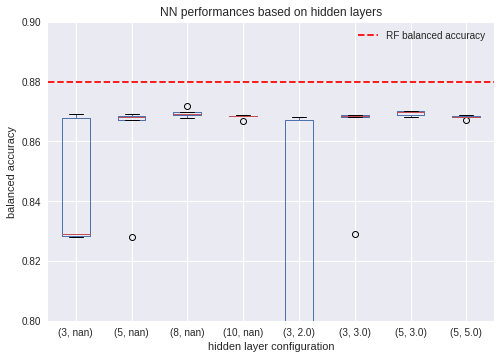

In [12]:
plt.style.use('seaborn')
results.boxplot()
plt.title('NN performances based on hidden layers')
plt.xlabel('hidden layer configuration')
plt.ylabel('balanced accuracy')
plt.axhline(0.88, color='r', linestyle='--', label='RF balanced accuracy')
plt.ylim([0.8, 0.9])

plt.legend()

In [13]:
results.max()

3   NaN    0.869185
5   NaN    0.869211
8   NaN    0.871889
10  NaN    0.868801
3   2      0.868267
    3      0.868904
5   3      0.870062
    5      0.868902
dtype: float64

## Trying with different alpha

In [14]:
mlp_layers_list = [(3, ), (8, ), (3, 2), (3, 3), (5, 5)]
n_reps = 5

accs2 = {}
for mlp_layers in tqdm(mlp_layers_list):
    accs2[mlp_layers] = []
    
    for n in range(n_reps):
        model = MLPClassifier(mlp_layers, alpha=0.000001)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        confusion_matrix(y_true=y_test, y_pred=y_pred)

        accs2[mlp_layers].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
pd.DataFrame(accs2).max()

3  NaN    0.868441
8  NaN    0.868979
3  2      0.868591
   3      0.868772
5  5      0.868643
dtype: float64

## Trying with different activation

In [16]:
mlp_layers_list = [(3, ), (8, ), (3, 2), (3, 3), (5, 5)]
n_reps = 5

accs3 = {}
for mlp_layers in tqdm(mlp_layers_list):
    accs3[mlp_layers] = []
    
    for n in range(n_reps):
        model = MLPClassifier(mlp_layers, alpha=0.000001, activation='tanh')

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        confusion_matrix(y_true=y_test, y_pred=y_pred)

        accs3[mlp_layers].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
pd.DataFrame(accs3).max()

3  NaN    0.868361
8  NaN    0.869337
3  2      0.868437
   3      0.869443
5  5      0.868898
dtype: float64

### Using tanh but with input values between -1 and 1

In [18]:
mlp_layers_list = [(3, ), (8, ), (3, 2), (3, 3), (5, 5)]
n_reps = 5

accs4 = {}
for mlp_layers in tqdm(mlp_layers_list):
    accs4[mlp_layers] = []
    
    for n in range(n_reps):
        model = MLPClassifier(mlp_layers, alpha=0.000001, activation='tanh')

        model.fit((X_train - 0.5) * 2, y_train)

        y_pred = model.predict((X_test - 0.5) * 2)

        confusion_matrix(y_true=y_test, y_pred=y_pred)

        accs4[mlp_layers].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
pd.DataFrame(accs4).max()

3  NaN    0.868721
8  NaN    0.869673
3  2      0.868977
   3      0.868361
5  5      0.869567
dtype: float64

In [20]:
pd.DataFrame(accs4)

3         8         3                   5
        NaN       NaN         2         3         5
0  0.866455  0.868668  0.866559  0.867380  0.869567
1  0.868002  0.867689  0.868926  0.867331  0.868720
2  0.868721  0.868874  0.867716  0.868361  0.867870
3  0.866866  0.868410  0.866404  0.867973  0.866942
4  0.866609  0.869673  0.868977  0.867433  0.868617

In [21]:
# To check overfitting
y_pred_train = model.predict((X_train - .5) * 2)
balanced_accuracy_score(y_true=y_train, y_pred=y_pred_train)

0.8757968484772802

## MLP models do not outperform RandomForest, now we try Linear models

In [22]:
from sklearn.linear_model import RidgeClassifier

### Ridge

In [23]:
alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
ridge_accs = []
for alpha in alphas:
    model = RidgeClassifier(alpha=alpha)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    confusion_matrix(y_true=y_test, y_pred=y_pred)

    ridge_accs.append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9a328b0f60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9a32899550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9a328b0d30>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9a32899b00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9a32899dd8>],
 'means': []}

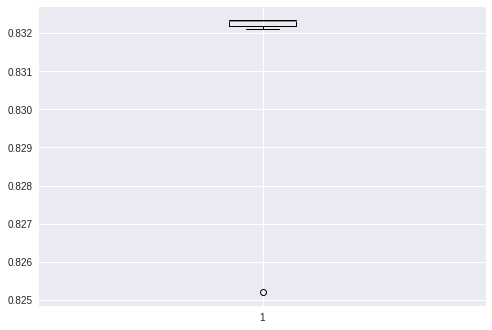

In [24]:
plt.boxplot(ridge_accs)

## No linear model seems to improve the RF, so we stick to RF